In [ ]:
import pandas as pd
import os
import sqlite3
import openmeteo_requests
import requests_cache
from retry_requests import retry
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Konfigurationsparameter
CONFIG = {
    "DB_PATH": "../nextbike_data_old.db",
    "WEATHER_API_URL": "https://archive-api.open-meteo.com/v1/archive",
    "CSV_BIKES": "city_summaries.csv",
    "CSV_WEATHER": "weather_data.csv",
    "LAT": 49.0094,
    "LON": 8.4044,
    "START_DATE": "2025-09-01",
    "END_DATE": "2025-10-31",
    "CITY_NAME": "Karlsruhe"
}

# Feiertage/Ferien für die day_type Klassifizierung
HOLIDAYS = [
    '2025-01-01', '2025-01-06', '2025-04-18', '2025-04-21', 
    '2025-05-01', '2025-05-29', '2025-06-09', '2025-06-19', 
    '2025-10-03', '2025-11-01', '2025-12-25', '2025-12-26'
]

In [ ]:
def get_nextbike_data(config):
    """Extrahiert die stündlichen Zusammenfassungsdaten aus der Nextbike-SQL-Datenbank"""
    # Falls CSV existiert, direkt laden
    if os.path.exists(config["CSV_BIKES"]):
        print(f"{config['CSV_BIKES']} gefunden. Lade lokale Daten.")
        return pd.read_csv(config["CSV_BIKES"])
    
    # Andernfalls SQL-Datenbank abfragen
    print("Keine CSV gefunden. Starte SQL-Extraktion...")
    try:
        conn = sqlite3.connect(config["DB_PATH"])
        
        # SQL-Abfrage zur Extraktion der stündlichen Zusammenfassungsdaten
        query = """
        SELECT 
            date(timestamp) as date, 
            strftime('%H', timestamp) as hour,
            AVG(available_bikes) as available_bikes, 
            AVG(booked_bikes) as booked_bikes,
            AVG(total_bikes) as total_bikes
        FROM city_summaries
        GROUP BY date, hour
        """
        # Daten aus der SQL-Datenbank in ein DataFrame laden
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        # DataFrame als CSV speichern
        df.to_csv(config["CSV_BIKES"], index=False)
        print("Die Nextbike-Datenbank wurde erfolgreich extrahiert. "
                f"Die Daten wurden in {config['CSV_BIKES']} gespeichert.")
        return df
        
    except sqlite3.Error as e:
        print(f"✗ SQL-Datenbank Fehler: {e}")
        return None


def get_weather_data(config):
    """Ruft Wetterdaten von der Open-Meteo API ab und speichert sie lokal als CSV."""
    # Falls CSV existiert, direkt laden
    if os.path.exists(config["CSV_WEATHER"]):
        print(f"{config['CSV_WEATHER']} gefunden. Lade lokale Daten.")
        return pd.read_csv(config["CSV_WEATHER"])
    
    # Andernfalls API abfragen
    print("Keine CSV gefunden. Rufe Wetterdaten von Open-Meteo ab...")
    try:
        cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)

        # API-Parameter definieren
        params = {
            "latitude": config["LAT"], "longitude": config["LON"],
            "start_date": config["START_DATE"], "end_date": config["END_DATE"],
            "hourly": ["temperature_2m", "rain", "wind_speed_10m", "relative_humidity_2m", "cloud_cover"],
            "timezone": "Europe/Berlin",
        }
        responses = openmeteo.weather_api(config["WEATHER_API_URL"], params=params)
        
        # Erste Antwort extrahieren
        res = responses[0]
        hourly = res.Hourly()

        # Daten in ein Dictionary umwandeln
        data = {"timestamp": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()), inclusive="left"
        )}
        # Wettervariablen hinzufügen
        for i, var in enumerate(params["hourly"]):
            data[var] = hourly.Variables(i).ValuesAsNumpy()

        # DataFrame erstellen und als CSV speichern
        df_weather = pd.DataFrame(data=data)
        df_weather.to_csv(config["CSV_WEATHER"], index=False)
        print("Die Wetterdaten wurden erfolgreich extrahiert. "
                f"Die Daten wurden in {config['CSV_WEATHER']} gespeichert.")
        return df_weather
    
    except Exception as e:
        print(f"✗ Wetter-API Fehler: {e}")
        return None

In [ ]:
# 1. Daten laden
print ("Starte Setup...")
bikes_df = get_nextbike_data(CONFIG)
weather_df = get_weather_data(CONFIG)

# 2. Vorbereitung zum Mergen (timestamps angleichen)
bikes_df['timestamp'] = pd.to_datetime(bikes_df['date'] + ' ' + bikes_df['hour'].astype(str).str.zfill(2) + ':00:00').dt.tz_localize('UTC')
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])

# 3. Sortieren und Mergen
merged_df = pd.merge_asof(
    bikes_df.sort_values('timestamp'),
    weather_df.sort_values('timestamp'),
    on='timestamp',
    direction='nearest'
)

# 4. day_type Spalte hinzufügen
def get_day_type(ts):
    """Bestimmt den Tagestyp basierend auf Datum."""
    date_str = ts.strftime('%Y-%m-%d')
    if date_str in HOLIDAYS:
        return 'Ferien'
    elif ts.weekday() >= 5:
        return 'Wochenende'
    else:
        return 'Wochentag'

merged_df['day_type'] = merged_df['timestamp'].apply(get_day_type)
day_types = ['Wochentag', 'Wochenende', 'Ferien']
colors = {'Wochentag': '#1f77b4', 'Wochenende': '#ff7f0e', 'Ferien': '#d62728'}

print("Setup abgeschlossen. 'merged_df' steht für Analysen bereit.")

city_summaries.csv gefunden. Lade lokale Daten.
weather_data.csv gefunden. Lade lokale Daten.
Setup abgeschlossen. 'merged_df' steht für Analysen bereit.


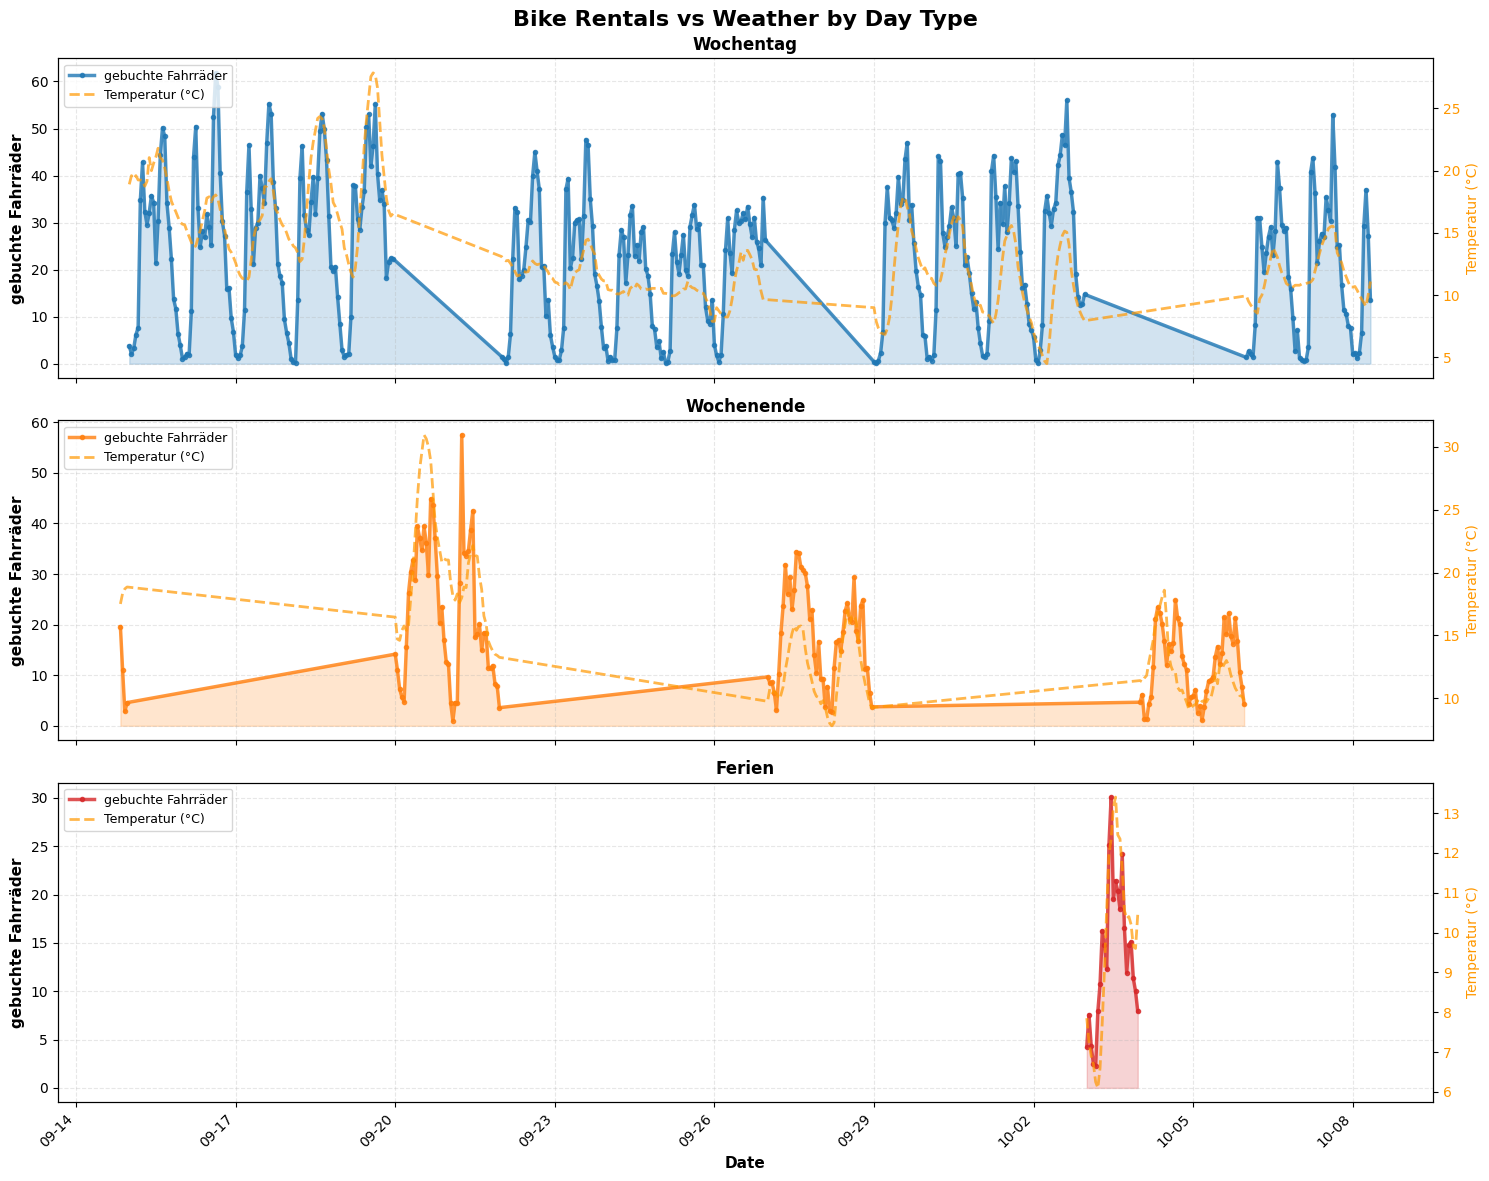

In [4]:
# FIGURE 1: Time Series by Day Type
fig1, axes1 = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig1.suptitle('Bike Rentals vs Weather by Day Type', fontsize=16, fontweight='bold')

for idx, day_type in enumerate(day_types):
    data = merged_df[merged_df['day_type'] == day_type]
    ax = axes1[idx]
    
    if len(data) == 0:
        ax.text(0.5, 0.5, f'No {day_type} data', ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Plot booked bikes
    ax.plot(data['timestamp'], data['booked_bikes'], 
            label='gebuchte Fahrräder', linewidth=2.5, color=colors[day_type], marker='o', markersize=3, alpha=0.8)
    ax.fill_between(data['timestamp'], data['booked_bikes'], alpha=0.2, color=colors[day_type])
    ax.set_ylabel('gebuchte Fahrräder', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_title(f'{day_type}', fontsize=12, fontweight='bold')
    
    # Add temperature overlay on secondary axis
    ax_temp = ax.twinx()
    ax_temp.plot(data['timestamp'], data['temperature_2m'], 
                 label='Temperatur (°C)', linewidth=2, color='#FF9800', linestyle='--', alpha=0.7)
    ax_temp.set_ylabel('Temperatur (°C)', fontsize=10, color='#FF9800')
    ax_temp.tick_params(axis='y', labelcolor='#FF9800')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    if idx == 2:
        ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_temp.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\gfabi\AppData\Local\Temp\ipykernel_11360\791902389.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_day_stats = merged_df.groupby(['temp_range', 'day_type'])['booked_bikes'].mean().unstack()
C:\Users\gfabi\AppData\Local\Temp\ipykernel_11360\791902389.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True)


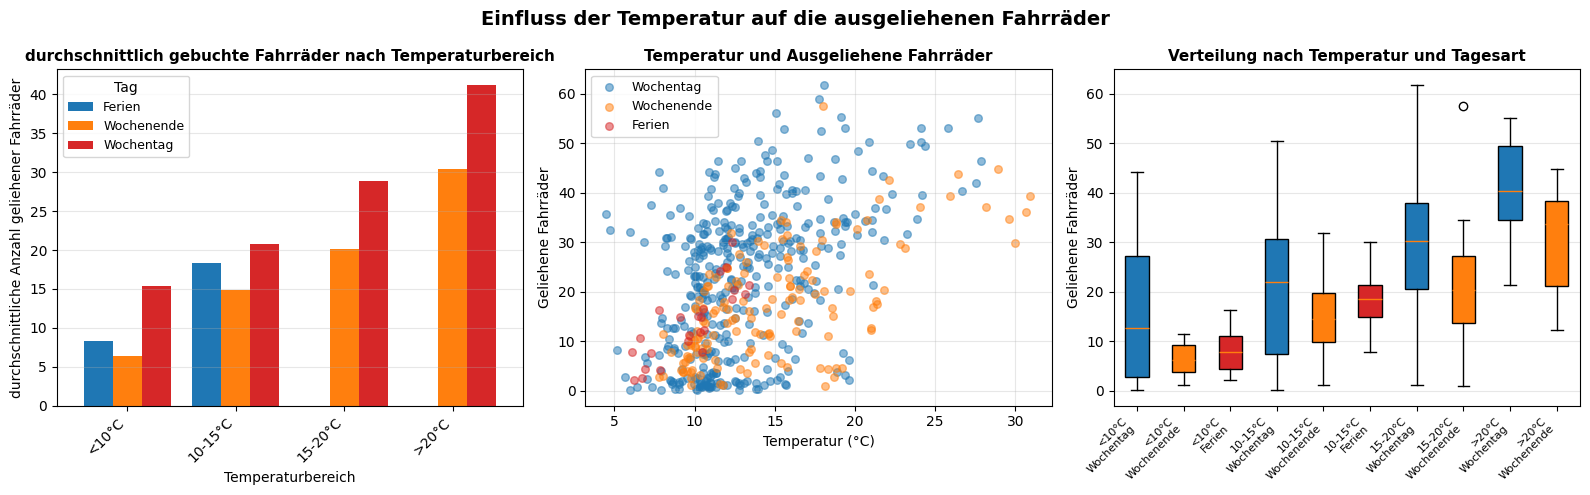

In [5]:
# FIGURE 2: Temperature Impact Analysis
fig2, axes2 = plt.subplots(1, 3, figsize=(16, 5))
fig2.suptitle('Einfluss der Temperatur auf die ausgeliehenen Fahrräder', fontsize=14, fontweight='bold')

# Define temperature ranges
merged_df['temp_range'] = pd.cut(merged_df['temperature_2m'], 
                                 bins=[-np.inf, 10, 15, 20, np.inf],
                                 labels=['<10°C', '10-15°C', '15-20°C', '>20°C'])

# Plot 1: Average booked bikes by temperature range and day type
ax = axes2[0]
temp_day_stats = merged_df.groupby(['temp_range', 'day_type'])['booked_bikes'].mean().unstack()
temp_day_stats.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#d62728'], width=0.8)
ax.set_title('durchschnittlich gebuchte Fahrräder nach Temperaturbereich', fontsize=11, fontweight='bold')
ax.set_ylabel('durchschnittliche Anzahl geliehener Fahrräder', fontsize=10)
ax.set_xlabel('Temperaturbereich', fontsize=10)
ax.legend(title='Tag', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Scatter plot - Temperature vs Booked Bikes (colored by day type)
ax = axes2[1]
for day_type, color in colors.items():
    data = merged_df[merged_df['day_type'] == day_type]
    ax.scatter(data['temperature_2m'], data['booked_bikes'], 
              label=day_type, alpha=0.5, s=30, color=color)
ax.set_title('Temperatur und Ausgeliehene Fahrräder', fontsize=11, fontweight='bold')
ax.set_xlabel('Temperatur (°C)', fontsize=10)
ax.set_ylabel('Geliehene Fahrräder', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Box plot - Distribution by temperature range and day type
ax = axes2[2]
data_for_box = []
labels_for_box = []
for temp_range in ['<10°C', '10-15°C', '15-20°C', '>20°C']:
    for day_type in ['Wochentag', 'Wochenende', 'Ferien']:
        subset = merged_df[(merged_df['temp_range'] == temp_range) & (merged_df['day_type'] == day_type)]['booked_bikes']
        if len(subset) > 0:
            data_for_box.append(subset)
            labels_for_box.append(f'{temp_range}\n{day_type}')

bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
for patch, label in zip(bp['boxes'], labels_for_box):
    if 'Wochentag' in label:
        patch.set_facecolor('#1f77b4')
    elif 'Wochenende' in label:
        patch.set_facecolor('#ff7f0e')
    else:
        patch.set_facecolor('#d62728')
ax.set_title('Verteilung nach Temperatur und Tagesart', fontsize=11, fontweight='bold')
ax.set_ylabel('Geliehene Fahrräder', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

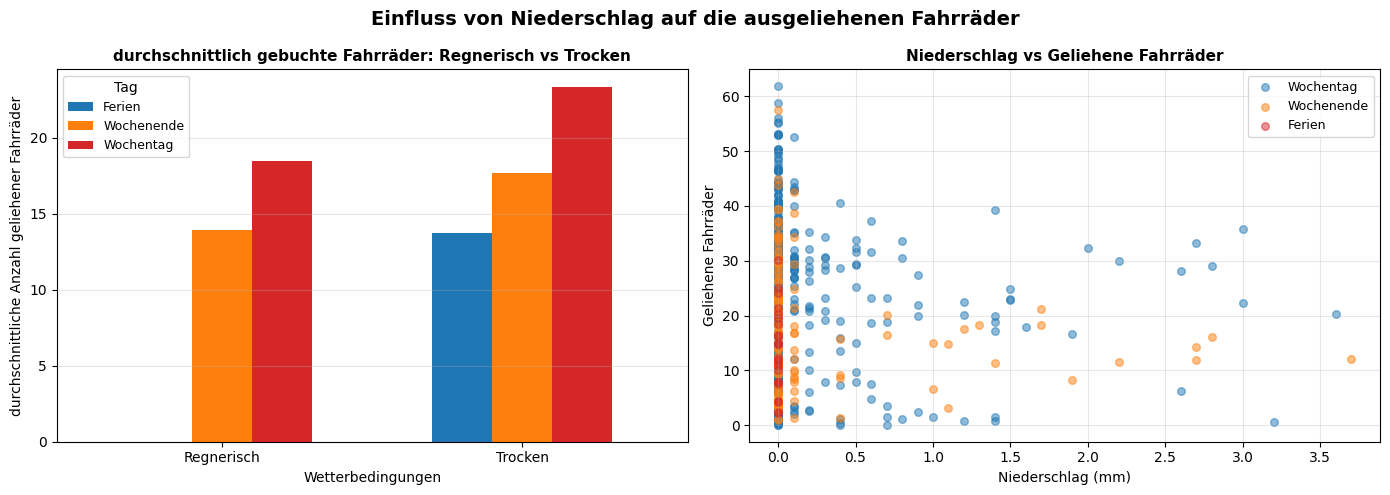

In [6]:
# FIGURE 3: Precipitation Impact Analysis
fig3, axes3 = plt.subplots(1, 2, figsize=(14, 5))
fig3.suptitle('Einfluss von Niederschlag auf die ausgeliehenen Fahrräder', fontsize=14, fontweight='bold')

# Define rain conditions
merged_df['rain_condition'] = merged_df['rain'].apply(lambda x: 'Regnerisch' if x > 0.5 else 'Trocken')

# Plot 1: Average booked bikes by rain condition and day type
ax = axes3[0]
rain_day_stats = merged_df.groupby(['rain_condition', 'day_type'])['booked_bikes'].mean().unstack()
rain_day_stats.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#d62728'], width=0.6)
ax.set_title('durchschnittlich gebuchte Fahrräder: Regnerisch vs Trocken', fontsize=11, fontweight='bold')
ax.set_ylabel('durchschnittliche Anzahl geliehener Fahrräder', fontsize=10)
ax.set_xlabel('Wetterbedingungen', fontsize=10)
ax.legend(title='Tag', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

# Plot 2: Scatter plot - Rain vs Booked Bikes
ax = axes3[1]
for day_type, color in colors.items():
    data = merged_df[merged_df['day_type'] == day_type]
    ax.scatter(data['rain'], data['booked_bikes'], 
              label=day_type, alpha=0.5, s=30, color=color)
ax.set_title('Niederschlag vs Geliehene Fahrräder', fontsize=11, fontweight='bold')
ax.set_xlabel('Niederschlag (mm)', fontsize=10)
ax.set_ylabel('Geliehene Fahrräder', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\gfabi\AppData\Local\Temp\ipykernel_11360\3772016321.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_rain = pearsonr(data['rain'].dropna(), data.loc[data['rain'].notna(), 'booked_bikes'])[0]
C:\Users\gfabi\AppData\Local\Temp\ipykernel_11360\3772016321.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


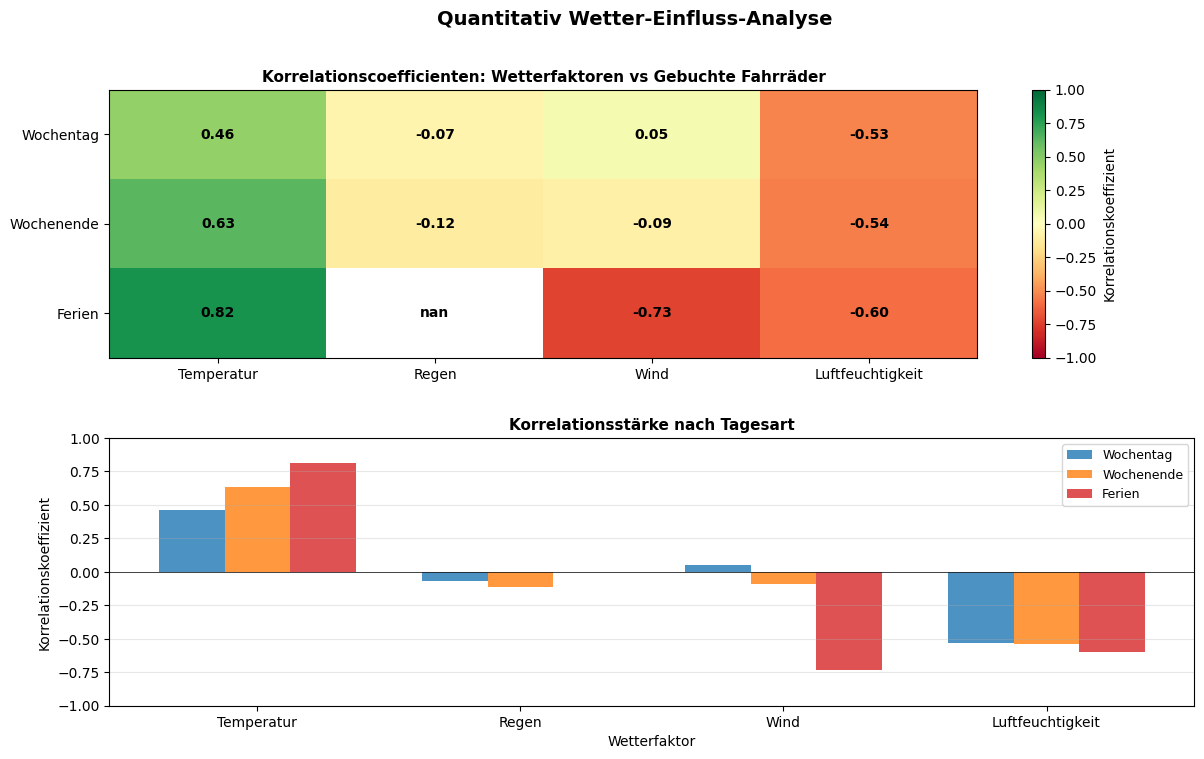

In [7]:
# FIGURE 4: Correlation Analysis
fig4 = plt.figure(figsize=(14, 8))
gs = fig4.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
fig4.suptitle('Quantitativ Wetter-Einfluss-Analyse', fontsize=14, fontweight='bold')

# Calculate correlations for each day type
correlations = {}
for day_type in day_types:
    data = merged_df[merged_df['day_type'] == day_type]
    if len(data) > 1:
        corr_temp = pearsonr(data['temperature_2m'].dropna(), data.loc[data['temperature_2m'].notna(), 'booked_bikes'])[0]
        corr_rain = pearsonr(data['rain'].dropna(), data.loc[data['rain'].notna(), 'booked_bikes'])[0]
        corr_wind = pearsonr(data['wind_speed_10m'].dropna(), data.loc[data['wind_speed_10m'].notna(), 'booked_bikes'])[0]
        corr_humidity = pearsonr(data['relative_humidity_2m'].dropna(), data.loc[data['relative_humidity_2m'].notna(), 'booked_bikes'])[0]
        
        correlations[day_type] = {
            'Temperatur': corr_temp,
            'Regen': corr_rain,
            'Wind': corr_wind,
            'Luftfeuchtigkeit': corr_humidity
        }

# Plot 1: Correlation heatmap
ax = fig4.add_subplot(gs[0, :])
corr_df = pd.DataFrame(correlations).T
im = ax.imshow(corr_df.values, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))
ax.set_xticklabels(corr_df.columns)
ax.set_yticklabels(corr_df.index)
ax.set_title('Korrelationscoefficienten: Wetterfaktoren vs Gebuchte Fahrräder', fontsize=11, fontweight='bold')

# Add text annotations
for i in range(len(corr_df.index)):
    for j in range(len(corr_df.columns)):
        text = ax.text(j, i, f'{corr_df.values[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

plt.colorbar(im, ax=ax, label='Korrelationskoeffizient')

# Plot 2: Bar chart of correlations
ax = fig4.add_subplot(gs[1, :])
x = np.arange(len(corr_df.columns))
width = 0.25

for i, day_type in enumerate(correlations.keys()):
    values = [correlations[day_type][col] for col in corr_df.columns]
    ax.bar(x + i*width, values, width, label=day_type, color=colors[day_type], alpha=0.8)

ax.set_ylabel('Korrelationskoeffizient', fontsize=10)
ax.set_xlabel('Wetterfaktor', fontsize=10)
ax.set_title('Korrelationsstärke nach Tagesart', fontsize=11, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(corr_df.columns)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

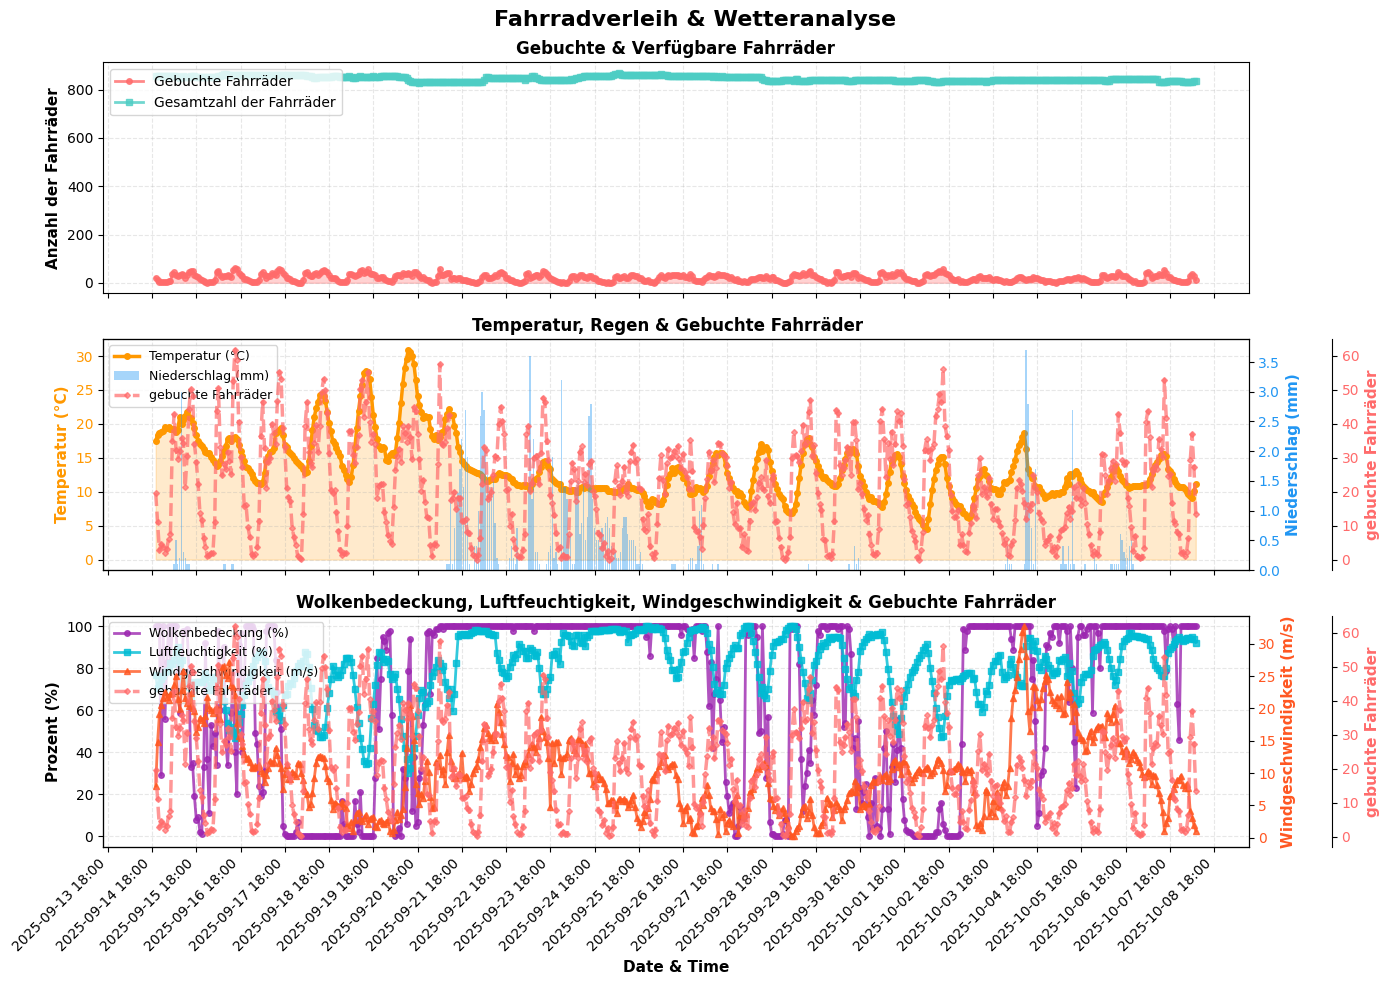

In [8]:
# FIGURE 5: Overall Time Series
fig5, axes5 = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig5.suptitle('Fahrradverleih & Wetteranalyse', fontsize=16, fontweight='bold')

# Plot 1: Booked bikes and total bikes
ax1 = axes5[0]
ax1.plot(merged_df['timestamp'], merged_df['booked_bikes'], 
         label='Gebuchte Fahrräder', linewidth=2, color='#FF6B6B', marker='o', markersize=4, alpha=0.8)
ax1.plot(merged_df['timestamp'], merged_df['total_bikes'], 
         label='Gesamtzahl der Fahrräder', linewidth=2, color='#4ECDC4', marker='s', markersize=4, alpha=0.8)
ax1.fill_between(merged_df['timestamp'], merged_df['booked_bikes'], alpha=0.3, color='#FF6B6B')
ax1.set_ylabel('Anzahl der Fahrräder', fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_title('Gebuchte & Verfügbare Fahrräder', fontsize=12, fontweight='bold')

# Plot 2: Temperature and Rain with Booked Bikes overlay
ax2 = axes5[1]
color_temp = '#FF9800'
ax2.plot(merged_df['timestamp'], merged_df['temperature_2m'], 
         label='Temperatur (°C)', linewidth=2.5, color=color_temp, marker='o', markersize=4)
ax2.fill_between(merged_df['timestamp'], merged_df['temperature_2m'], alpha=0.2, color=color_temp)
ax2.set_ylabel('Temperatur (°C)', fontsize=11, fontweight='bold', color=color_temp)
ax2.tick_params(axis='y', labelcolor=color_temp)

# Add rain as bar chart on secondary axis
ax2_rain = ax2.twinx()
ax2_rain.bar(merged_df['timestamp'], merged_df['rain'], 
             label='Niederschlag (mm)', alpha=0.4, color='#2196F3', width=0.03)
ax2_rain.set_ylabel('Niederschlag (mm)', fontsize=11, fontweight='bold', color='#2196F3')
ax2_rain.tick_params(axis='y', labelcolor='#2196F3')

# Add booked bikes on tertiary axis with proper scaling
ax2_bikes = ax2.twinx()
ax2_bikes.spines['right'].set_position(('outward', 60))
ax2_bikes.plot(merged_df['timestamp'], merged_df['booked_bikes'], 
               label='gebuchte Fahrräder', linewidth=2.5, color='#FF6B6B', marker='D', markersize=3, alpha=0.7, linestyle='--')
ax2_bikes.set_ylabel('gebuchte Fahrräder', fontsize=11, fontweight='bold', color='#FF6B6B')
ax2_bikes.tick_params(axis='y', labelcolor='#FF6B6B')

ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_title('Temperatur, Regen & Gebuchte Fahrräder   ', fontsize=12, fontweight='bold')

# Add legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_rain.get_legend_handles_labels()
lines3, labels3 = ax2_bikes.get_legend_handles_labels()
ax2.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', fontsize=9)

# Plot 3: Cloud cover, humidity, wind, and booked bikes
ax3 = axes5[2]
ax3.plot(merged_df['timestamp'], merged_df['cloud_cover'], 
         label='Wolkenbedeckung (%)', linewidth=2, color='#9C27B0', marker='o', markersize=4, alpha=0.8)
ax3.plot(merged_df['timestamp'], merged_df['relative_humidity_2m'], 
         label='Luftfeuchtigkeit (%)', linewidth=2, color='#00BCD4', marker='s', markersize=4, alpha=0.8)
ax3.set_ylabel('Prozent (%)', fontsize=11, fontweight='bold')

ax3_wind = ax3.twinx()
ax3_wind.plot(merged_df['timestamp'], merged_df['wind_speed_10m'], 
              label='Windgeschwindigkeit (m/s)', linewidth=2, color='#FF5722', marker='^', markersize=4, alpha=0.8)
ax3_wind.set_ylabel('Windgeschwindigkeit (m/s)', fontsize=11, fontweight='bold', color='#FF5722')
ax3_wind.tick_params(axis='y', labelcolor='#FF5722')

# Add booked bikes on tertiary axis
ax3_bikes = ax3.twinx()
ax3_bikes.spines['right'].set_position(('outward', 60))
ax3_bikes.plot(merged_df['timestamp'], merged_df['booked_bikes'], 
               label='gebuchte Fahrräder', linewidth=2.5, color='#FF6B6B', marker='D', markersize=3, alpha=0.7, linestyle='--')
ax3_bikes.set_ylabel('gebuchte Fahrräder', fontsize=11, fontweight='bold', color='#FF6B6B')
ax3_bikes.tick_params(axis='y', labelcolor='#FF6B6B')

ax3.set_xlabel('Date & Time', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_title('Wolkenbedeckung, Luftfeuchtigkeit, Windgeschwindigkeit & Gebuchte Fahrräder', fontsize=12, fontweight='bold')

# Add legends
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_wind.get_legend_handles_labels()
lines3, labels3 = ax3_bikes.get_legend_handles_labels()
ax3.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', fontsize=9)

# Format x-axis
for ax in axes5:
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

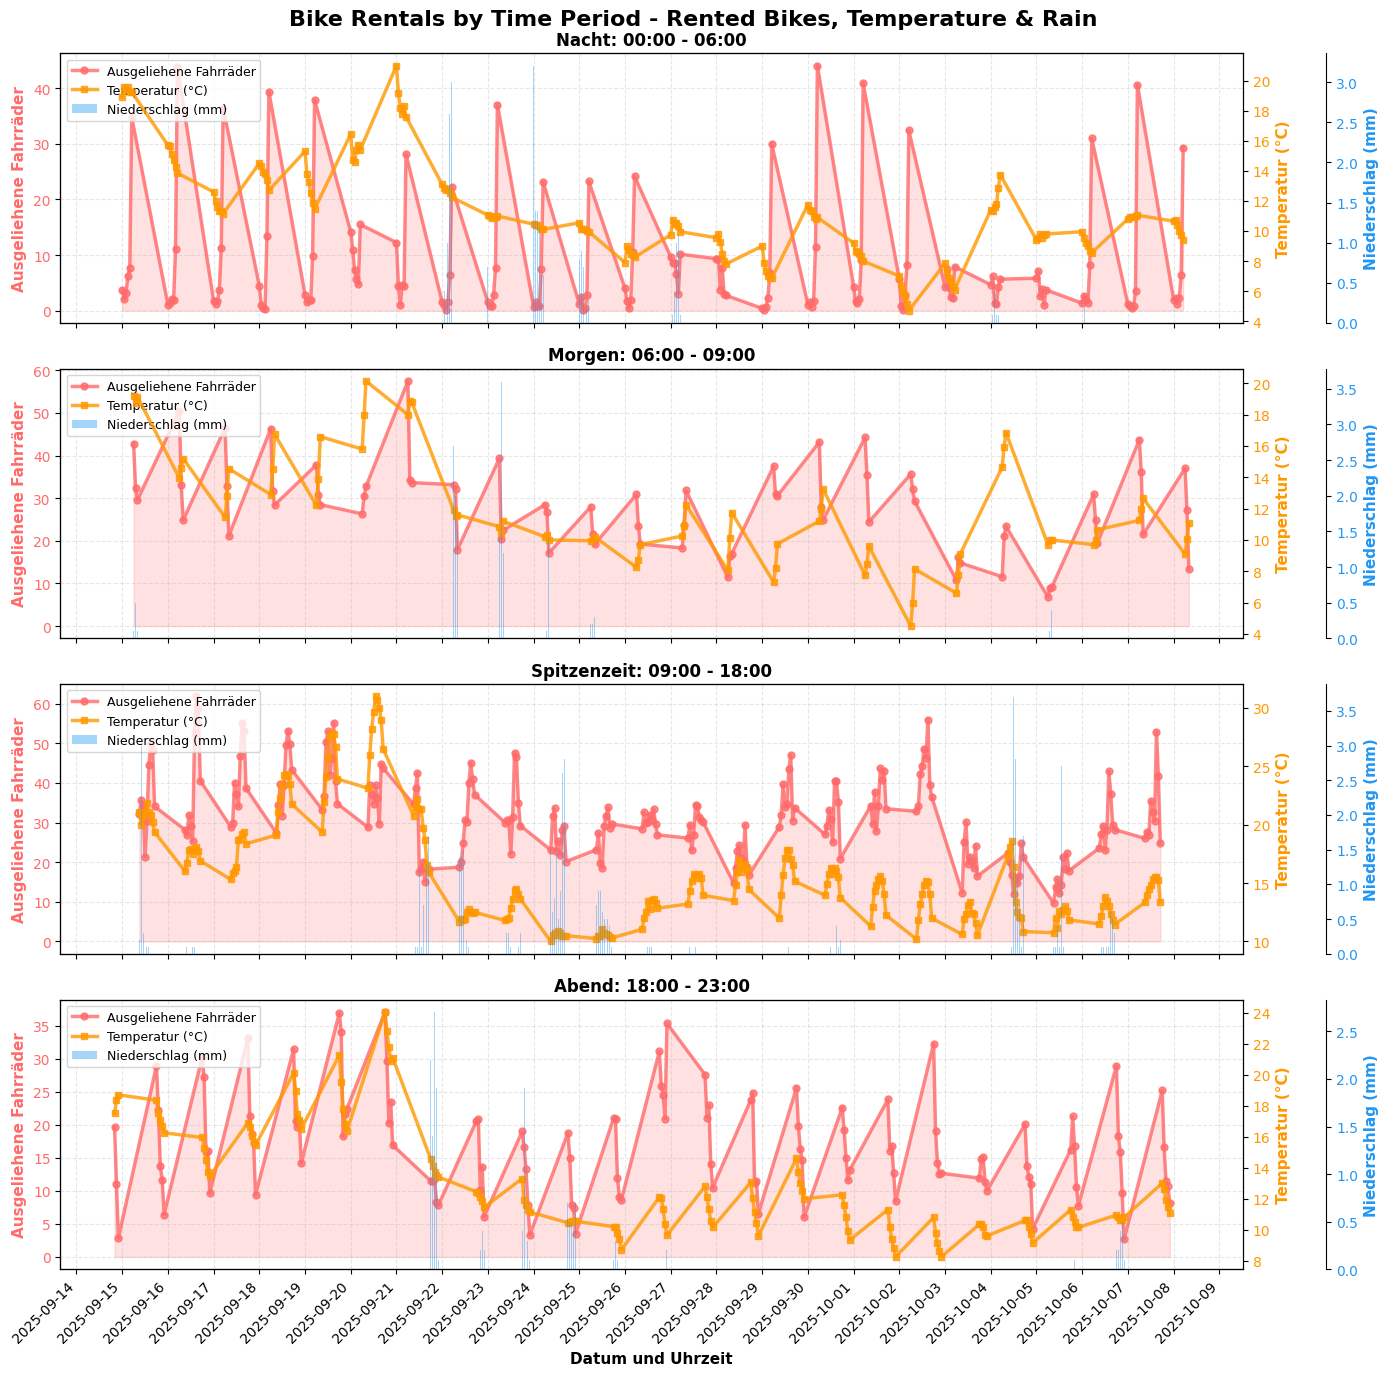

In [9]:
# FIGURE 6: Period Comparison
fig6, axes6 = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig6.suptitle('Bike Rentals by Time Period - Rented Bikes, Temperature & Rain', fontsize=16, fontweight='bold')

# Define time periods based on analysis
# Period 1: Night (00:00-06:00) - Low activity (3.12 avg)
night_mask = (merged_df['timestamp'].dt.hour >= 0) & (merged_df['timestamp'].dt.hour < 6)
night_df = merged_df[night_mask].copy()

# Period 2: Morning (06:00-09:00) - Medium activity (17.46 avg)
morning_mask = (merged_df['timestamp'].dt.hour >= 6) & (merged_df['timestamp'].dt.hour < 9)
morning_df = merged_df[morning_mask].copy()

# Period 3: Peak Day (09:00-18:00) - Highest activity (30.95 avg)
peak_mask = (merged_df['timestamp'].dt.hour >= 9) & (merged_df['timestamp'].dt.hour < 18)
peak_df = merged_df[peak_mask].copy()

# Period 4: Evening (18:00-23:00) - Second peak (16.86 avg)
evening_mask = (merged_df['timestamp'].dt.hour >= 18) & (merged_df['timestamp'].dt.hour < 23)
evening_df = merged_df[evening_mask].copy()

periods = [
    (night_df, "Nacht: 00:00 - 06:00", 0),
    (morning_df, "Morgen: 06:00 - 09:00", 1),
    (peak_df, "Spitzenzeit: 09:00 - 18:00", 2),
    (evening_df, "Abend: 18:00 - 23:00", 3)
]

for period_data, title, idx in periods:
    ax_main = axes6[idx]
    
    # Plot booked bikes
    ax_main.plot(period_data['timestamp'], period_data['booked_bikes'], 
                 label='Ausgeliehene Fahrräder', linewidth=2.5, color='#FF6B6B', marker='o', markersize=5, alpha=0.8)
    ax_main.fill_between(period_data['timestamp'], period_data['booked_bikes'], alpha=0.2, color='#FF6B6B')
    ax_main.set_ylabel('Ausgeliehene Fahrräder', fontsize=11, fontweight='bold', color='#FF6B6B')
    ax_main.tick_params(axis='y', labelcolor='#FF6B6B')
    
    # Add temperature on secondary axis
    ax_temp = ax_main.twinx()
    ax_temp.plot(period_data['timestamp'], period_data['temperature_2m'], 
                 label='Temperatur (°C)', linewidth=2.5, color='#FF9800', marker='s', markersize=4, alpha=0.8)
    ax_temp.set_ylabel('Temperatur (°C)', fontsize=11, fontweight='bold', color='#FF9800')
    ax_temp.tick_params(axis='y', labelcolor='#FF9800')
    
    # Add rain on tertiary axis
    ax_rain = ax_main.twinx()
    ax_rain.spines['right'].set_position(('outward', 60))
    ax_rain.bar(period_data['timestamp'], period_data['rain'], 
                label='Niederschlag (mm)', alpha=0.4, color='#2196F3', width=0.02)
    ax_rain.set_ylabel('Niederschlag (mm)', fontsize=11, fontweight='bold', color='#2196F3')
    ax_rain.tick_params(axis='y', labelcolor='#2196F3')
    
    if idx == 3:
        ax_main.set_xlabel('Datum und Uhrzeit', fontsize=11, fontweight='bold')
    
    ax_main.grid(True, alpha=0.3, linestyle='--')
    ax_main.set_title(title, fontsize=12, fontweight='bold')
    
    # Add legends
    lines1, labels1 = ax_main.get_legend_handles_labels()
    lines2, labels2 = ax_temp.get_legend_handles_labels()
    lines3, labels3 = ax_rain.get_legend_handles_labels()
    ax_main.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', fontsize=9)

# Format x-axis for period figure
for ax in axes6:
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [10]:
# statistische Zusammenfassung und Erkenntnisse
print("="*70)
print("STATISTISCHE ZUSAMMENFASSUNG")
print("="*70)

for day_type in day_types:
    data = merged_df[merged_df['day_type'] == day_type]
    print(f"\n{day_type.upper()}:")
    print(f"  Datenpunkte: {len(data)}")
    print(f"  Gebuchte Fahrräder - Mittelwert: {data['booked_bikes'].mean():.2f}, "
          f"Min: {data['booked_bikes'].min():.2f}, Max: {data['booked_bikes'].max():.2f}")
    print(f"  Temperatur - Mittelwert: {data['temperature_2m'].mean():.2f}°C, "
          f"Bereich: {data['temperature_2m'].min():.2f}°C bis {data['temperature_2m'].max():.2f}°C")
    print(f"  Regnerische Stunden: {(data['rain'] > 0.5).sum()} ({(data['rain'] > 0.5).sum()/len(data)*100:.1f}%)")

# Zusätzliche Metriken
print("\n" + "="*70)
print("ZUSÄTZLICHE METRIKEN")
print("="*70)

# Gesamte Anzahl Ausleihen pro Tag (Durchschnitt)
daily_totals = merged_df.groupby(merged_df['timestamp'].dt.date)['booked_bikes'].sum()
avg_daily_rentals = daily_totals.mean()
print(f"Gesamte Ausleihen pro Tag (Durchschnitt): {avg_daily_rentals:.2f}")

# Durchschnittsausleihen pro Stunde
avg_hourly_rentals = merged_df['booked_bikes'].mean()
print(f"Durchschnittliche Ausleihen pro Stunde: {avg_hourly_rentals:.2f}")

# Hauptpendeltage (Tage mit höchster Aktivität)
day_of_week_avg = merged_df.groupby(merged_df['timestamp'].dt.day_name())['booked_bikes'].mean().sort_values(ascending=False)
print(f"Hauptpendeltage (nach durchschnittlicher Aktivität):")
for day, avg in day_of_week_avg.head(3).items():
    print(f"  {day}: {avg:.2f} Ausleihen/Stunde")

# Fahrten pro Stunde vs. Temperatur (Korrelationsanalyse)
temp_corr = merged_df['temperature_2m'].corr(merged_df['booked_bikes'])
print(f"Korrelation zwischen Temperatur und Ausleihen pro Stunde: {temp_corr:.3f}")

print("\n" + "="*70)
print("KORRELATIONSKOEFFIZIENTEN")
print("="*70)
for day_type in day_types:
    print(f"\n{day_type.upper()}:")
    if day_type in correlations:
        for factor, corr in correlations[day_type].items():
            strength = "Stark" if abs(corr) > 0.6 else "Moderat" if abs(corr) > 0.3 else "Schwach"
            direction = "Positiv" if corr > 0 else "Negativ"
            print(f"  {factor:12} → {corr:7.3f} ({direction:8} - {strength})")
    else:
        print("  Keine Korrelationen verfügbar (unzureichende Daten)")

print("\n" + "="*70)
print("WICHTIGSTE ERKENNTNISSE")
print("="*70)

# Find strongest correlations
all_corrs = []
for day_type, factors in correlations.items():
    for factor, corr in factors.items():
        all_corrs.append((day_type, factor, corr))

all_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
print("\nStärkste Korrelationen (nach absolutem Wert):")
for day_type, factor, corr in all_corrs[:5]:
    print(f"  {factor:12} bei {day_type:10} → {corr:7.3f}")

# Temperature impact
print("\nTemperatureinfluss:")
for temp_range in ['<10°C', '10-15°C', '15-20°C', '>20°C']:
    avg = merged_df[merged_df['temp_range'] == temp_range]['booked_bikes'].mean()
    count = len(merged_df[merged_df['temp_range'] == temp_range])
    print(f"  {temp_range:10} → {avg:6.2f} Fahrräder im Durchschnitt ({count} Beobachtungen)")

# Rain impact
print("\nRegeneinfluss:")
dry_avg = merged_df[merged_df['rain_condition'] == 'Trocken']['booked_bikes'].mean()
rainy_avg = merged_df[merged_df['rain_condition'] == 'Regnerisch']['booked_bikes'].mean()
print(f"  Trockene Bedingungen  → {dry_avg:6.2f} Fahrräder im Durchschnitt")
print(f"  Regnerische Bedingungen → {rainy_avg:6.2f} Fahrräder im Durchschnitt")
print(f"  Unterschied          → {dry_avg - rainy_avg:6.2f} Fahrräder ({(dry_avg - rainy_avg)/rainy_avg*100:.1f}% mehr)")

STATISTISCHE ZUSAMMENFASSUNG

WOCHENTAG:
  Datenpunkte: 393
  Gebuchte Fahrräder - Mittelwert: 22.79, Min: 0.08, Max: 61.83
  Temperatur - Mittelwert: 13.13°C, Bereich: 4.50°C bis 27.85°C
  Regnerische Stunden: 43 (10.9%)

WOCHENENDE:
  Datenpunkte: 148
  Gebuchte Fahrräder - Mittelwert: 17.22, Min: 1.00, Max: 57.50
  Temperatur - Mittelwert: 14.79°C, Bereich: 7.80°C bis 30.95°C
  Regnerische Stunden: 17 (11.5%)

FERIEN:
  Datenpunkte: 24
  Gebuchte Fahrräder - Mittelwert: 13.73, Min: 2.25, Max: 30.08
  Temperatur - Mittelwert: 9.73°C, Bereich: 6.10°C bis 13.40°C
  Regnerische Stunden: 0 (0.0%)

ZUSÄTZLICHE METRIKEN
Gesamte Ausleihen pro Tag (Durchschnitt): 473.33
Durchschnittliche Ausleihen pro Stunde: 20.94
Hauptpendeltage (nach durchschnittlicher Aktivität):
  Thursday: 23.73 Ausleihen/Stunde
  Tuesday: 22.77 Ausleihen/Stunde
  Friday: 22.01 Ausleihen/Stunde
Korrelation zwischen Temperatur und Ausleihen pro Stunde: 0.460

KORRELATIONSKOEFFIZIENTEN

WOCHENTAG:
  Temperatur   →   0.45